In [222]:
# Import relevant packages
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
from scipy.interpolate import interp1d

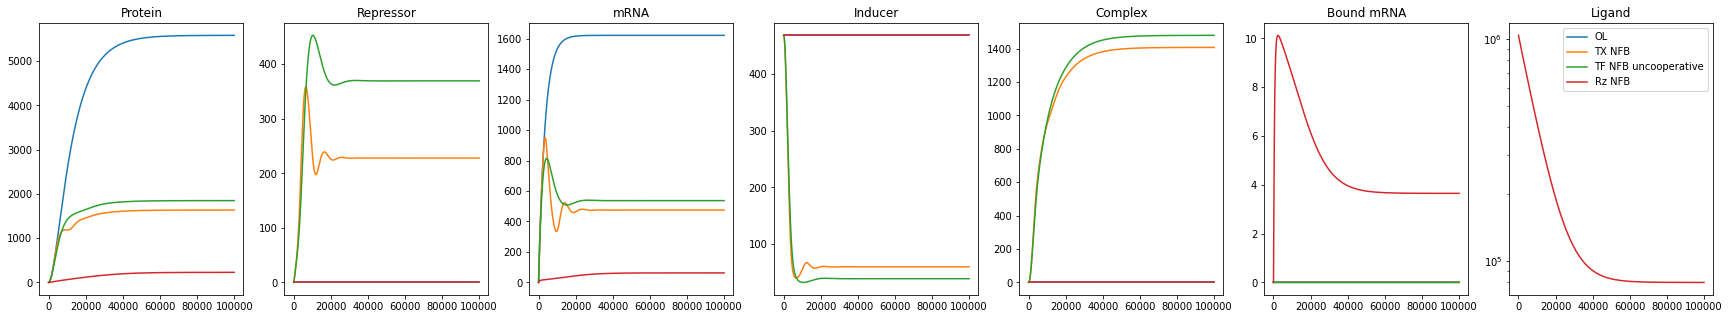

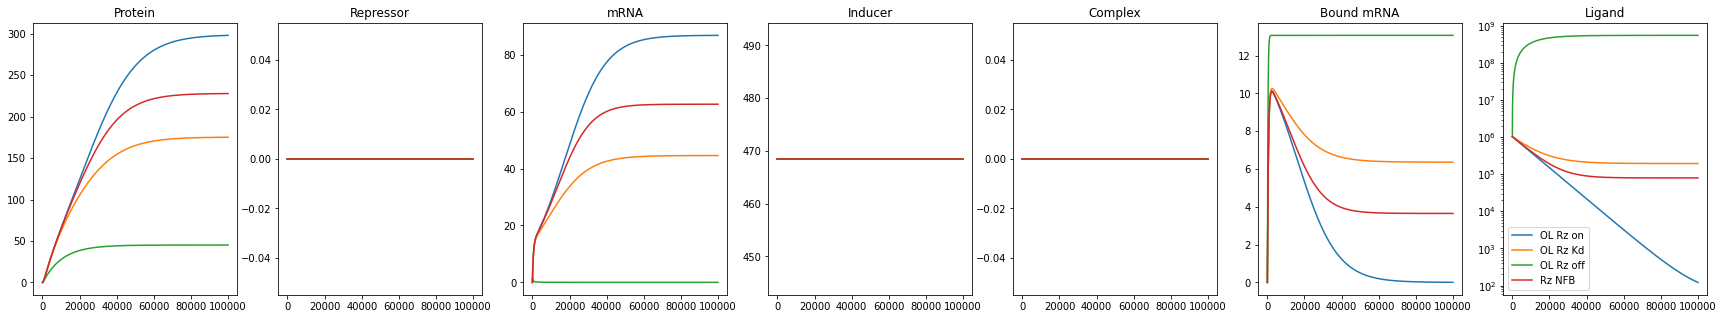

In [220]:
'''
species:
    i, inducer
    r, repressor (tetR)
    c, inducer-repressor complex (inactive repressor)
    l, ligand for Rz
    m, mRNA
    mb, mRNA with Rz bound to ligand
    p, protein output (reporter)
reactions:
    0 -> i -> 0         k_influx, k_degi        influx and deg of inducer
    i + r <-> c -> 0    k_on, k_off, k_degp     binding of inducer & repressor, complex deg
    [0] -> r -> 0       PROD_R, k_degp          production and deg of repressor
    0 -> m -> 0         f(r), k_degm            TX and deg of mRNA -- f(r) = k_TX*theta^n/(theta^n + r^n)
    m + l <-> mb -> l   k_a, k_d, k_degm        binding of ligand & mRNA (Rz), bound mRNA deg with ligand recycling
    0 -> l -> 0         PROD_L, DEG_L           production and deg of ligand
    m, mb -> 0, l       k_cl, k_clb             cleavage of Rz (deg of mRNA & bound mRNA) with ligand recycling
    [0] -> p -> 0       k_TL*(m+mb), k_degp     production and deg of protein
functions:  PROD_R          PROD_L          DEG_L
    OL:     0               0               0
    OFF:    0               k_in            k_degl*l
    TX NFB: k_TL*(m+mb)     0               0
    Rz NFB: 0               k_TL*(m+mb)     k_degp
'''
def ode_OL(t,x,params,extra):
    
    k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n = params
    i,r,c,m,mb,l,p = x
    alpha, beta = extra

    # OL: open loop
    #PROD_R = k_TX*k_TL/k_degm
    PROD_R = 0
    PROD_L = 0
    DEG_L = 0
    k_cl = 0
    
    di = k_influx - k_degi*i - k_on*i*r + k_off*c
    dr = PROD_R - k_degp*r - k_on*i*r + k_off*c
    dc = -k_degp*c + k_on*i*r - k_off*c
    dm = k_TX*alpha*theta**n/(theta**n + r**n) - k_degm*m - k_a*m*l + k_d*mb - k_cl*m
    dmb = -k_degm*mb + k_a*m*l - k_d*mb - k_clb*mb
    dl = PROD_L - DEG_L - k_a*m*l + k_d*mb
    dp = k_TL*(m+mb) - k_degp*p

    return [di,dr,dc,dm,dmb,dl,dp]

def ode_OL_Rz(t,x,params,extra):
    
    k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n = params
    i,r,c,m,mb,l,p = x
    alpha, beta = extra

    # OFF: open loop, with constitutively active sm-responsive ribozyme
    PROD_R = 0
    #PROD_L = k_in
    #DEG_L = k_degl*l
    PROD_L = k_TL*k_TX/k_degm * beta
    DEG_L = k_degp*l
    
    di = k_influx - k_degi*i - k_on*i*r + k_off*c
    dr = PROD_R - k_degp*r - k_on*i*r + k_off*c
    dc = -k_degp*c + k_on*i*r - k_off*c
    dm = k_TX*alpha*theta**n/(theta**n + r**n) - k_degm*m - k_a*m*l + k_d*mb - k_cl*m
    dmb = -k_degm*mb + k_a*m*l - k_d*mb - k_clb*mb
    dl = PROD_L - DEG_L - k_a*m*l + k_d*mb + k_degm*mb + k_clb*mb
    #dl = 0
    dp = k_TL*(m+mb) - k_degp*p

    return [di,dr,dc,dm,dmb,dl,dp]

def ode_OL_TX(t,x,params,extra):
    
    k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n = params
    i,r,c,m,mb,l,p = x
    alpha, beta = extra

    PROD_R = k_TX*k_TL/k_degm*beta
    PROD_L = 0
    DEG_L = 0
    k_cl = 0
    
    di = k_influx - k_degi*i - k_on*i*r + k_off*c
    dr = PROD_R - k_degp*r - k_on*i*r + k_off*c
    dc = -k_degp*c + k_on*i*r - k_off*c
    dm = k_TX*alpha*theta**n/(theta**n + r**n) - k_degm*m - k_a*m*l + k_d*mb - k_cl*m
    dmb = -k_degm*mb + k_a*m*l - k_d*mb - k_clb*mb
    dl = PROD_L - DEG_L - k_a*m*l + k_d*mb
    dp = k_TL*(m+mb) - k_degp*p

    return [di,dr,dc,dm,dmb,dl,dp]

def ode_OL_TX_uncoop(t,x,params,extra):
    
    k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n = params
    i,r,c,m,mb,l,p = x
    alpha, beta = extra

    PROD_R = k_TX*k_TL/k_degm*beta
    PROD_L = 0
    DEG_L = 0
    k_cl = 0
    n = 1
    
    di = k_influx - k_degi*i - k_on*i*r + k_off*c
    dr = PROD_R - k_degp*r - k_on*i*r + k_off*c
    dc = -k_degp*c + k_on*i*r - k_off*c
    dm = k_TX*alpha*theta**n/(theta**n + r**n) - k_degm*m - k_a*m*l + k_d*mb - k_cl*m
    dmb = -k_degm*mb + k_a*m*l - k_d*mb - k_clb*mb
    dl = PROD_L - DEG_L - k_a*m*l + k_d*mb
    dp = k_TL*(m+mb) - k_degp*p

    return [di,dr,dc,dm,dmb,dl,dp]

def ode_TX(t,x,params,extra):
    
    k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n = params
    i,r,c,m,mb,l,p = x
    alpha, beta = extra

    # TX NFB: repressor represses its own production
    PROD_R = k_TL*(m+mb)
    PROD_L = 0
    DEG_L = 0
    k_cl = 0
    
    di = k_influx - k_degi*i - k_on*i*r + k_off*c
    dr = PROD_R - k_degp*r - k_on*i*r + k_off*c
    dc = -k_degp*c + k_on*i*r - k_off*c
    dm = k_TX*alpha*theta**n/(theta**n + r**n) - k_degm*m #- k_a*m*l + k_d*mb - k_cl*m
    dmb = -k_degm*mb + k_a*m*l - k_d*mb - k_clb*mb
    dl = PROD_L - DEG_L - k_a*m*l + k_d*mb
    dp = k_TL*(m+mb) - k_degp*p

    return [di,dr,dc,dm,dmb,dl,dp]

def ode_TX_uncoop(t,x,params,extra):
    
    k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n = params
    i,r,c,m,mb,l,p = x
    alpha, beta = extra

    # TX NFB: repressor represses its own production
    PROD_R = k_TL*(m+mb)
    PROD_L = 0
    DEG_L = 0
    k_cl = 0
    n = 1
    
    di = k_influx - k_degi*i - k_on*i*r + k_off*c
    dr = PROD_R - k_degp*r - k_on*i*r + k_off*c
    dc = -k_degp*c + k_on*i*r - k_off*c
    dm = k_TX*alpha*theta**n/(theta**n + r**n) - k_degm*m #- k_a*m*l + k_d*mb - k_cl*m
    dmb = -k_degm*mb + k_a*m*l - k_d*mb - k_clb*mb
    dl = PROD_L - DEG_L - k_a*m*l + k_d*mb
    dp = k_TL*(m+mb) - k_degp*p

    return [di,dr,dc,dm,dmb,dl,dp]

def ode_Rz(t,x,params,extra):
    
    k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n = params
    i,r,c,m,mb,l,p = x
    alpha, beta = extra

    # Rz: negative feedback via ribozyme
    PROD_R = 0
    PROD_L = k_TL*(m+mb)*beta
    DEG_L = k_degp*l
    
    di = k_influx - k_degi*i - k_on*i*r + k_off*c
    dr = PROD_R - k_degp*r - k_on*i*r + k_off*c
    dc = -k_degp*c + k_on*i*r - k_off*c
    dm = k_TX*alpha*theta**n/(theta**n + r**n) - k_degm*m - k_a*m*l + k_d*mb - k_cl*m
    dmb = -k_degm*mb + k_a*m*l - k_d*mb - k_clb*mb
    dl = PROD_L - DEG_L - k_a*m*l + k_d*mb + k_degm*mb + k_clb*mb
    dp = k_TL*(m+mb) - k_degp*p

    return [di,dr,dc,dm,dmb,dl,dp]

# Define parameters
vol_cell = 4e-12 # L
k_influx = 1.56*1e-1 # molec/s
#k_influx = 1.56 # molec/s
#k_influx = 0 # molec/s
k_degi = 3.33e-4 # 1/s
k_in = 1.56*1e10 # molec/s   # copied k_influx for dox
k_degl = 3.33e-4 # 1/s  # copied k_deg for dox
k_on = 1e-5 # 1/(molec*s)
k_off = 2e-8 # 1/s
k_degp = 9.67e-5 # 1/s
k_degm = 2.88e-4 # 1/s
'''
# Theo
k_a = 9.0e6 / 60 / vol_cell / 6.022e23 # 1/(M*min) * min/s / L / molec/mol = molec/s
k_d = 3.78 / 60 # 1/min * min/s = 1/s
k_cl = 0.140 / 60 # 1/min * min/s = 1/s
k_clb = 0.025 / 60 # 1/min * min/s = 1/s
# MS2-A3
k_a = 4.52e4 / 60 / vol_cell / 6.022e23 # 1/(M*min) * min/s / L / molec/mol = molec/s
k_d = 1.34e-2 / 60 # 1/min * min/s = 1/s
k_cl = 0.228 / 60 # 1/min * min/s = 1/s
k_clb = 0.0563 / 60 # 1/min * min/s = 1/s
'''
# MS2-B1
k_a = 2.6e4 / vol_cell / 6.022e23 # 1/(M*s) / L / molec/mol = molec/s
k_d = 1.12e-2 # 1/s
k_cl = 0.015 / 60 # 1/min * min/s = 1/s
k_clb = 0.197 / 60 # 1/min * min/s = 1/s

k_TX = 0.0467 # 1/s
k_TL = 3.33e-4 # 1/s
theta = 183 # molec
n = 4
alpha = 1

params = [k_influx, k_degi, k_in, k_degl,  k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
outs = []
outs2 = []
tspan = [0,1e5]
i0 = k_influx/k_degi
#l0 = k_in/k_degl
l0 = k_d/k_a
extra = [10,0]
ss_lig_off = k_TL*k_TX*alpha/k_degm/k_degp

# OL
#r0 = k_TX*k_TL/k_degm/k_degp
x0 = [i0, 0, 0, 0, 0, 0, 0]
out_OL = sp.integrate.solve_ivp(ode_OL, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
outs.append(out_OL)

# TX NFB
x0 = [i0, 0, 0, 0, 0, 0, 0]
out_TX = sp.integrate.solve_ivp(ode_TX, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
outs.append(out_TX)

# TX NFB uncooperative
x0 = [i0, 0, 0, 0, 0, 0, 0]
out_TX_uncoop = sp.integrate.solve_ivp(ode_TX_uncoop, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
outs.append(out_TX_uncoop)

# fully ON
x0 = [i0, 0, 0, 0, 0, l0, 0]
extra_on = [alpha,1e-1]
out_OL_on = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra_on), rtol=1e-10, atol=1e-10)
outs2.append(out_OL_on)

# halfway on/off
x0 = [i0, 0, 0, 0, 0, l0, 0]
extra_kd = [alpha,3.5e2]
out_OL_kd = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra_kd), rtol=1e-10, atol=1e-10)
outs2.append(out_OL_kd)

# fully OFF
x0 = [i0, 0, 0, 0, 0, l0, 0]
extra_off = [alpha,1e6]
out_OL_off = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra_off), rtol=1e-10, atol=1e-10)
outs2.append(out_OL_off)

# Rz NFB
x0 = [i0, 0, 0, 0, 0, l0, 0]
extra_kd = [alpha,3.5e2]
out_Rz = sp.integrate.solve_ivp(ode_Rz, tspan, x0, method='Radau', args=(params,extra_kd), rtol=1e-10, atol=1e-10)
outs.append(out_Rz)
outs2.append(out_Rz)

# Figure 1: OL, TX, Rz
fig,ax = plt.subplots(1,7,figsize=(30,5))

for out in outs:
    ax[0].plot(out.t, out.y[6])
    ax[1].plot(out.t, out.y[1])
    ax[2].plot(out.t, out.y[3])
    ax[3].plot(out.t, out.y[0])
    ax[4].plot(out.t, out.y[2])
    ax[5].plot(out.t, out.y[4])
    ax[6].plot(out.t, out.y[5])
    #ax[7].plot(out_TX.t, out_TX.y[1]+out_TX.y[2])

ax[0].set_title('Protein')
ax[1].set_title('Repressor')
ax[2].set_title('mRNA')
ax[3].set_title('Inducer')
ax[4].set_title('Complex')
ax[5].set_title('Bound mRNA')
ax[6].set_title('Ligand')
ax[6].set_yscale('log')
#ax[7].set_title('Total Repressor')

plt.legend(['OL','TX NFB','TF NFB uncooperative','Rz NFB'])

# Figure 2: OL Rz
fig,ax = plt.subplots(1,7,figsize=(30,5))

for out in outs2:
    ax[0].plot(out.t, out.y[6])
    ax[1].plot(out.t, out.y[1])
    ax[2].plot(out.t, out.y[3])
    ax[3].plot(out.t, out.y[0])
    ax[4].plot(out.t, out.y[2])
    ax[5].plot(out.t, out.y[4])
    ax[6].plot(out.t, out.y[5])
    #ax[7].plot(out_TX.t, out_TX.y[1]+out_TX.y[2])

ax[0].set_title('Protein')
ax[1].set_title('Repressor')
ax[2].set_title('mRNA')
ax[3].set_title('Inducer')
ax[4].set_title('Complex')
ax[5].set_title('Bound mRNA')
ax[6].set_title('Ligand')
ax[6].set_yscale('log')
#ax[7].set_title('Total Repressor')

plt.legend(['OL Rz on','OL Rz Kd','OL Rz off','Rz NFB'])


## Dose response curves

Text(0, 0.5, 'steady state protein')

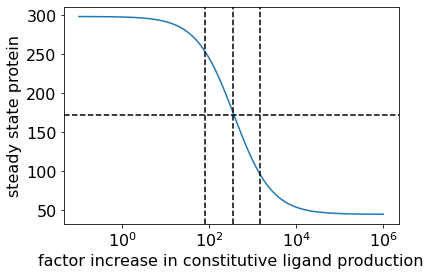

In [361]:
params = [k_influx, k_degi, k_in, k_degl,  k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
tspan = [0,1e5]
i0 = k_influx/k_degi
l0 = k_d/k_a
betas_Rz = np.logspace(-1,6,100)
outs_Rz = np.zeros((7,np.size(betas_Rz)))

for b,beta in enumerate(betas_Rz):
    x0 = [i0, 0, 0, 0, 0, l0, 0]
    extra = [alpha,beta]
    out_Rz = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
    outs_Rz[:,b] = out_Rz.y[:,-1]

plt.plot(betas_Rz,outs_Rz[6])
plt.xscale('log')
#plt.axvline(l0/ss_lig_off)
plt.axvline(3.5e2,ls='--',color='k')
plt.axvline(8e1,ls='--',color='k')
plt.axvline(1.5e3,ls='--',color='k')
Kd_Rz = outs_Rz[6,-1]+(outs_Rz[6,0]-outs_Rz[6,-1])/2
plt.axhline(Kd_Rz,ls='--',color='k')
plt.xlabel('factor increase in constitutive ligand production')
plt.ylabel('steady state protein')

Text(0, 0.5, 'steady state protein')

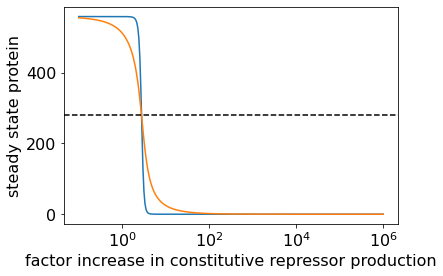

In [371]:
params = [k_influx, k_degi, k_in, k_degl,  k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
tspan = [0,1e5]
i0 = k_influx/k_degi
l0 = k_d/k_a
betas = np.logspace(-1,6,300)
outs = np.zeros((7,np.size(betas)))
outs_uncoop = np.zeros((7,np.size(betas)))

for b,beta in enumerate(betas):
    x0 = [i0, 0, 0, 0, 0, 0, 0]
    extra = [alpha,beta]
    out_OL_TX = sp.integrate.solve_ivp(ode_OL_TX, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
    outs[:,b] = out_OL_TX.y[:,-1]

    x0 = [i0, 0, 0, 0, 0, 0, 0]
    extra = [alpha,beta]
    out_OL_TX_uncoop = sp.integrate.solve_ivp(ode_OL_TX_uncoop, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
    outs_uncoop[:,b] = out_OL_TX_uncoop.y[:,-1]

plt.plot(betas,outs[6])
plt.plot(betas,outs_uncoop[6])
plt.xscale('log')
#plt.axvline(l0/ss_lig_off)
#plt.axvline(3.5e2,ls='--',color='k')
#plt.axvline(8e1,ls='--',color='k')
#plt.axvline(1.5e3,ls='--',color='k')
plt.axhline(outs[6,-1]+(outs[6,0]-outs[6,-1])/2,ls='--',color='k')
plt.xlabel('factor increase in constitutive repressor production')
plt.ylabel('steady state protein')

[14.954182121921418, 2.7500540612073507, 1.001053953577145]


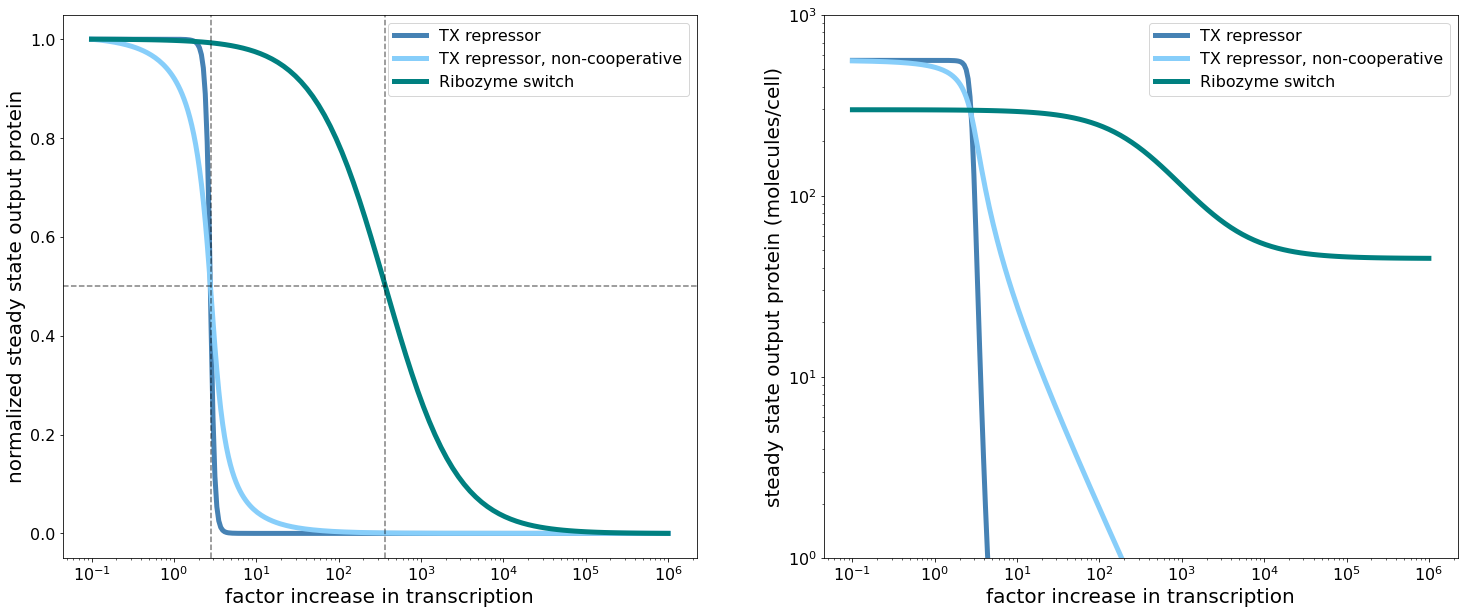

In [378]:
ns = []
out_list = [outs,outs_uncoop,outs_Rz]
beta_list = [betas,betas,betas_Rz] 
#beta_list = [b*k_TL*k_TX/k_degm/k_degp for b in beta_list]
colors = ['steelblue','lightskyblue','teal']

fig,ax = plt.subplots(1,2,figsize=(25,10))

for i in range(len(out_list)):
    out = out_list[i]
    b = beta_list[i]
    out_norm = out[6] - min(out[6])
    out_norm = out_norm / max(out_norm)
    f = interp1d(out_norm,b)
    nH = np.log10(81) / np.log10(f(0.1)/f(0.9))
    ns.append(nH)
    ax[0].plot(b,out_norm,color=colors[i],linewidth=5)
    ax[1].plot(b,out[6],color=colors[i],linewidth=5)

print(ns)
ax[0].set_xscale('log')
ax[0].legend(['TX repressor','TX repressor, non-cooperative','Ribozyme switch'])
ax[0].set_xlabel('factor increase in transcription', fontsize=20)
ax[0].set_ylabel('normalized steady state output protein', fontsize=20)
ax[0].axhline(0.5,color='black',alpha=0.5,ls='--')
ax[0].axvline(2.8,color='black',alpha=0.5,ls='--')
ax[0].axvline(3.7e2,color='black',alpha=0.5,ls='--')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(['TX repressor','TX repressor, non-cooperative','Ribozyme switch'])
ax[1].set_xlabel('factor increase in transcription', fontsize=20)
ax[1].set_ylabel('steady state output protein (molecules/cell)', fontsize=20)
ax[1].set_ylim((1e0,1e3))

fig.savefig('./figs/dose-response.jpg')

## Initial plot

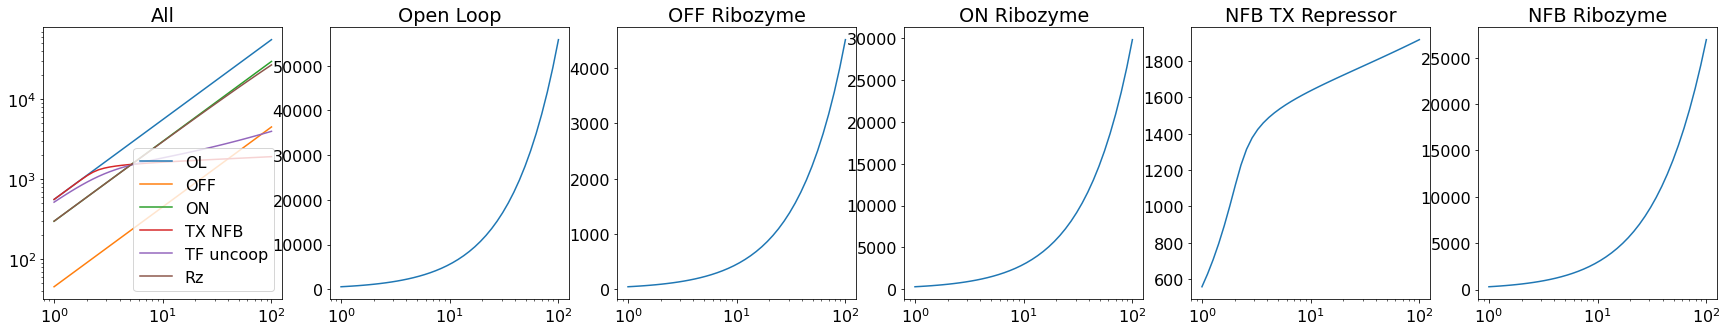

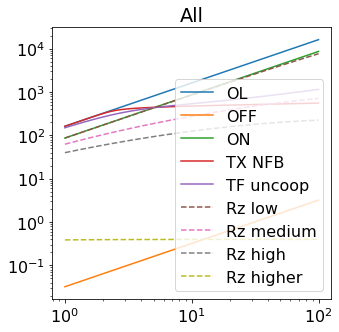

In [309]:
def vary_input(alphas):
    params = [k_influx, k_degi, k_in, k_degl,  k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
    out_ss = np.zeros((9,7,np.size(alphas)))
    tspan = [0,1e5]
    i0 = k_influx/k_degi
    l0 = k_d/k_a
    
    for a,alpha in enumerate(alphas):
        extra = [alpha,0]
        x0 = [i0, 0, 0, 0, 0, 0, 0]
        out_OL = sp.integrate.solve_ivp(ode_OL, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[0,:,a] = out_OL.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, l0, 0]
        extra_off = [alpha,1e6]
        out_OFF = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra_off), rtol=1e-10, atol=1e-10)
        out_ss[1,:,a] = out_OFF.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, l0, 0]
        extra_on = [alpha,1e-1]
        out_ON = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra_on), rtol=1e-10, atol=1e-10)
        out_ss[2,:,a] = out_ON.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        out_TX = sp.integrate.solve_ivp(ode_TX, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[3,:,a] = out_TX.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_low = [alpha,1] # changed from 8e1
        out_Rz = sp.integrate.solve_ivp(ode_Rz, tspan, x0, method='Radau', args=(params,extra_low), rtol=1e-10, atol=1e-10)
        out_ss[4,:,a] = out_Rz.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_kd = [alpha,3.5e2]
        out_Rz = sp.integrate.solve_ivp(ode_Rz, tspan, x0, method='Radau', args=(params,extra_kd), rtol=1e-10, atol=1e-10)
        out_ss[5,:,a] = out_Rz.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_high = [alpha,1.5e3]
        out_Rz = sp.integrate.solve_ivp(ode_Rz, tspan, x0, method='Radau', args=(params,extra_high), rtol=1e-10, atol=1e-10)
        out_ss[6,:,a] = out_Rz.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_higher = [alpha,1e6]
        out_Rz = sp.integrate.solve_ivp(ode_Rz, tspan, x0, method='Radau', args=(params,extra_higher), rtol=1e-10, atol=1e-10)
        out_ss[7,:,a] = out_Rz.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra = [alpha,0]
        out_TX_uncoop = sp.integrate.solve_ivp(ode_TX_uncoop, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[8,:,a] = out_TX_uncoop.y[:,-1]

    return out_ss


alphas = np.logspace(0,2,40)
out_ss = vary_input(alphas)
#display(out_ss)

# Figure 1
fig,ax = plt.subplots(1,6,figsize=(30,5))

ax[0].plot(alphas,out_ss[0,6,:])
ax[0].plot(alphas,out_ss[1,6,:])
ax[0].plot(alphas,out_ss[2,6,:])
ax[0].plot(alphas,out_ss[3,6,:])
ax[0].plot(alphas,out_ss[8,6,:])
ax[0].plot(alphas,out_ss[4,6,:])
ax[0].set_title('All')
ax[0].legend(['OL','OFF','ON','TX NFB','TF uncoop','Rz'])
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].plot(alphas,out_ss[0,6,:])
ax[1].set_title('Open Loop')
ax[1].set_xscale('log')
ax[2].plot(alphas,out_ss[1,6,:])
ax[2].set_title('OFF Ribozyme')
ax[2].set_xscale('log')
ax[3].plot(alphas,out_ss[2,6,:])
ax[3].set_title('ON Ribozyme')
ax[3].set_xscale('log')
ax[4].plot(alphas,out_ss[3,6,:])
ax[4].set_title('NFB TX Repressor')
ax[4].set_xscale('log')
ax[5].plot(alphas,out_ss[4,6,:])
ax[5].set_title('NFB Ribozyme')
ax[5].set_xscale('log')

# Figure 2
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(alphas,out_ss[0,3,:])
ax.plot(alphas,out_ss[1,3,:])
ax.plot(alphas,out_ss[2,3,:])
ax.plot(alphas,out_ss[3,3,:])
ax.plot(alphas,out_ss[8,3,:])
ax.plot(alphas,out_ss[4,3,:],ls='--')
ax.plot(alphas,out_ss[5,3,:],ls='--')
ax.plot(alphas,out_ss[6,3,:],ls='--')
ax.plot(alphas,out_ss[7,3,:],ls='--')
ax.set_title('All')
ax.legend(['OL','OFF','ON','TX NFB','TF uncoop','Rz low','Rz medium', 'Rz high', 'Rz higher'])
ax.set_xscale('log')
ax.set_yscale('log')

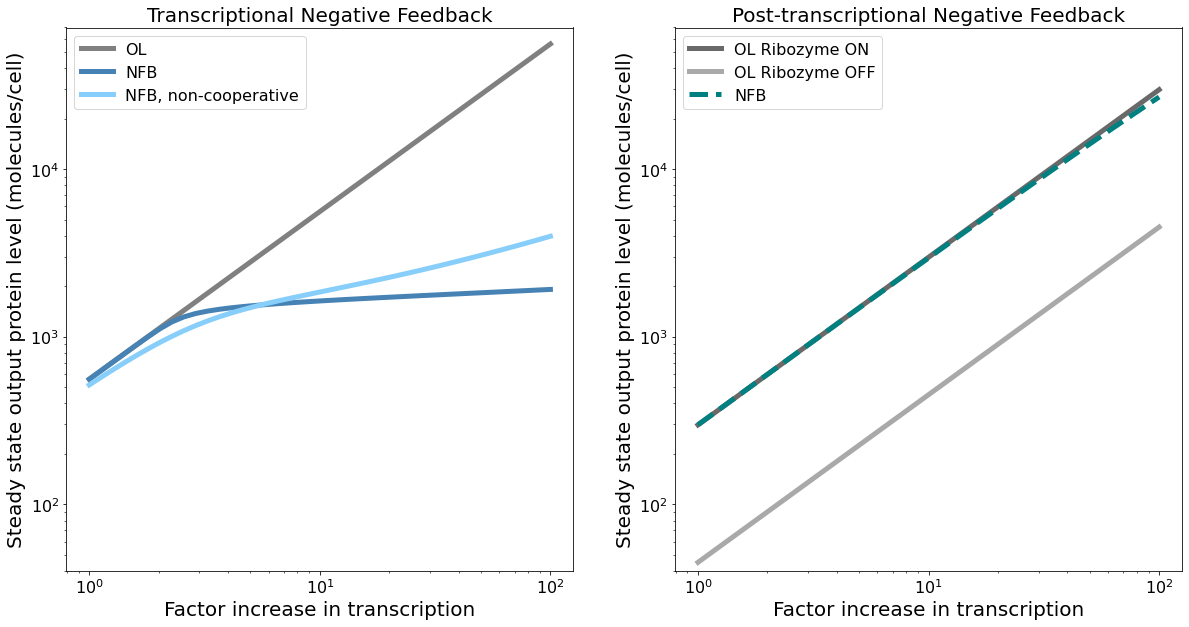

In [284]:
# Make nice plot
# Figure 1
fig,ax = plt.subplots(1,2,figsize=(20,10))
plt.rcParams['font.size'] = '16'

ax[0].plot(alphas,out_ss[0,6,:],color='gray',linewidth=5) # OL
ax[0].plot(alphas,out_ss[3,6,:],color='steelblue',linewidth=5) # TX
ax[0].plot(alphas,out_ss[8,6,:],color='lightskyblue',linewidth=5) # TX uncoop

ax[1].plot(alphas,out_ss[2,6,:],color='dimgray',linewidth=5) # ON
ax[1].plot(alphas,out_ss[1,6,:],color='darkgray',linewidth=5) # OFF
ax[1].plot(alphas,out_ss[4,6,:],color='teal',linewidth=5,ls='--') # Rz


ax[0].set_xlabel('Factor increase in transcription', fontsize=20)
ax[0].set_ylabel('Steady state output protein level (molecules/cell)', fontsize=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim((4e1,7e4))
ax[0].set_title('Transcriptional Negative Feedback',fontsize=20)
ax[0].legend(['OL','NFB','NFB, non-cooperative'])

ax[1].set_xlabel('Factor increase in transcription', fontsize=20)
ax[1].set_ylabel('Steady state output protein level (molecules/cell)', fontsize=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim((4e1,7e4))
ax[1].set_title('Post-transcriptional Negative Feedback',fontsize=20)
ax[1].legend(['OL Ribozyme ON','OL Ribozyme OFF','NFB'])

fig.savefig('./figs/inital-attempt.jpg')

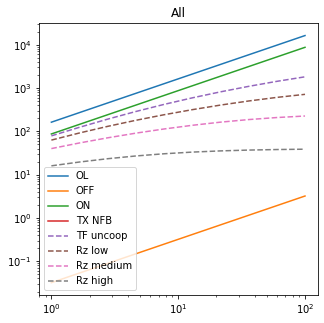

In [209]:
# Figure 2
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(alphas,out_ss[0,3,:])
ax.plot(alphas,out_ss[1,3,:])
ax.plot(alphas,out_ss[2,3,:])
ax.plot(alphas,out_ss[3,3,:])
ax.plot(alphas,out_ss[8,3,:])
ax.plot(alphas,out_ss[4,3,:],ls='--')
ax.plot(alphas,out_ss[5,3,:],ls='--')
ax.plot(alphas,out_ss[6,3,:],ls='--')
ax.plot(alphas,out_ss[7,3,:],ls='--')
ax.set_title('All')
ax.legend(['OL','OFF','ON','TX NFB','TF uncoop','Rz low','Rz medium', 'Rz high', 'Rz higher'])
ax.set_xscale('log')
ax.set_yscale('log')

## Parameter variation

KeyboardInterrupt: 

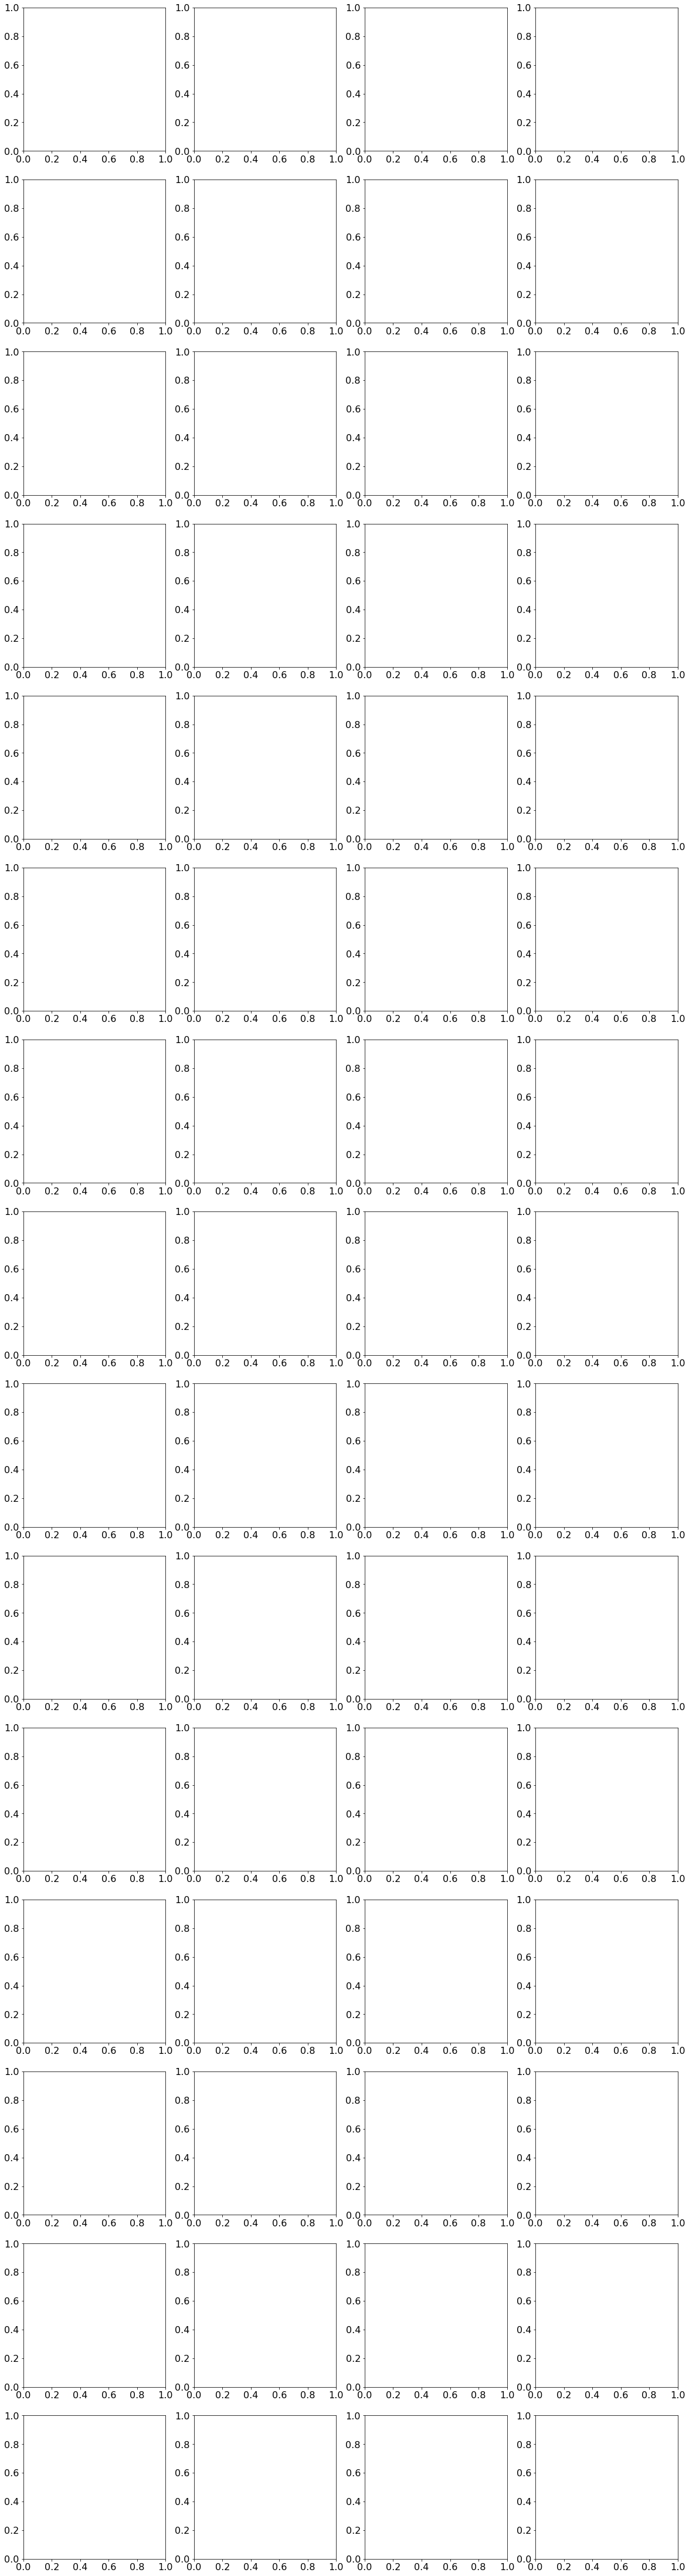

In [286]:
# Parameter variation

def vary_input2(alphas,params):
    out_ss = np.zeros((4,7,np.size(alphas)))
    tspan = [0,1e5]
    i0 = k_influx/k_degi
    l0 = k_d/k_a
    
    for a,alpha in enumerate(alphas):
        extra = [alpha,0]
        x0 = [i0, 0, 0, 0, 0, 0, 0]
        out_OL = sp.integrate.solve_ivp(ode_OL, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[0,:,a] = out_OL.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        out_TX = sp.integrate.solve_ivp(ode_TX, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[1,:,a] = out_TX.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra = [alpha,0]
        out_TX_uncoop = sp.integrate.solve_ivp(ode_TX_uncoop, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[2,:,a] = out_TX_uncoop.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_low = [alpha,1]
        out_Rz = sp.integrate.solve_ivp(ode_Rz, tspan, x0, method='Radau', args=(params,extra_low), rtol=1e-10, atol=1e-10)
        out_ss[3,:,a] = out_Rz.y[:,-1]

    return out_ss[:,6,:]

params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
param_names = ['k_influx', 'k_degi', 'k_in', 'k_degl', 'k_on', 'k_off', 'k_degp', 'k_degm', 'k_a', 'k_d', 'k_cl', 'k_clb', 'k_TX', 'k_TL', 'theta', 'n']
#alphas = np.logspace(0,2,5)
#factors = np.logspace(-2,2,5)
alphas = [1,3,10,30,100]
factors = [0.1,1,10]
fig,ax = plt.subplots(len(params_orig)-1,4,figsize=(20,len(params_orig)*5))

for i in range(len(params_orig)-1):
    for factor in factors:
        params = params_orig
        params[i] = params[i]*factor
        out_ss = vary_input2(alphas,params)
        ax[i,0].plot(alphas,out_ss[0,:])
        ax[i,1].plot(alphas,out_ss[1,:])
        ax[i,2].plot(alphas,out_ss[2,:])
        ax[i,3].plot(alphas,out_ss[3,:])
    ax[i,0].set_xscale('log')
    ax[i,1].set_xscale('log')
    ax[i,2].set_xscale('log')
    ax[i,3].set_xscale('log')
    ax[i,0].set_yscale('log')
    ax[i,1].set_yscale('log')
    ax[i,2].set_yscale('log')
    ax[i,3].set_yscale('log')
    ax[i,0].set_ylabel(param_names[i])

ax[0,0].set_title('Open Loop')
ax[0,1].set_title('TX NFB')
ax[0,2].set_title('TX NFB non-coop')
ax[0,3].set_title('Ribozyme NFB')
ax[0,0].legend(['0.1x','1x','10x'])

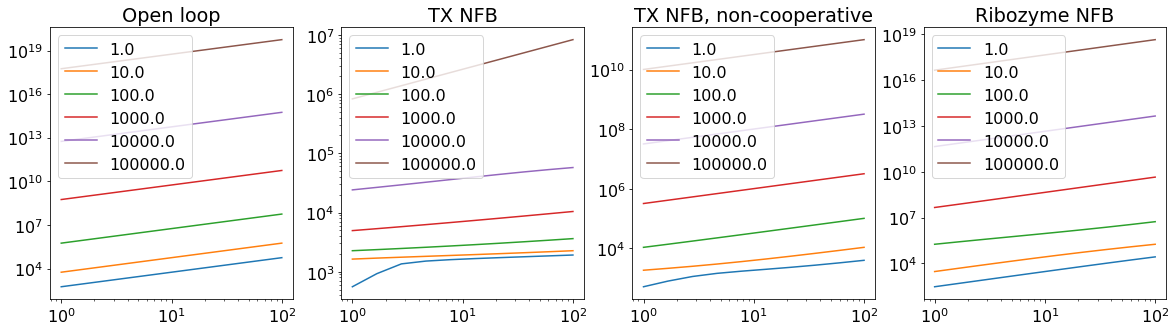

In [288]:
def vary_input2(alphas,params):
    out_ss = np.zeros((4,7,np.size(alphas)))
    tspan = [0,1e5]
    i0 = k_influx/k_degi
    l0 = k_d/k_a
    
    for a,alpha in enumerate(alphas):
        extra = [alpha,0]
        x0 = [i0, 0, 0, 0, 0, 0, 0]
        out_OL = sp.integrate.solve_ivp(ode_OL, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[0,:,a] = out_OL.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        out_TX = sp.integrate.solve_ivp(ode_TX, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[1,:,a] = out_TX.y[:,-1]
        
        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra = [alpha,0]
        out_TX_uncoop = sp.integrate.solve_ivp(ode_TX_uncoop, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[2,:,a] = out_TX_uncoop.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_low = [alpha,1]
        out_Rz = sp.integrate.solve_ivp(ode_Rz, tspan, x0, method='Radau', args=(params,extra_low), rtol=1e-10, atol=1e-10)
        out_ss[3,:,a] = out_Rz.y[:,-1]

    return out_ss[:,6,:]

# Translation rate seems to be important
params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
alphas = np.logspace(0,2,10)
factors = np.logspace(0,5,6)
fig,ax = plt.subplots(1,4,figsize=(20,5))
i = 13

outs = np.zeros((4,len(alphas),len(factors)))

for f,factor in enumerate(factors):
    params = params_orig
    params[i] = params[i]*factor
    out_ss = vary_input2(alphas,params)
    outs[:,:,f] = out_ss
    #ax[0].plot(alphas,out_ss[0,:])
    #ax[1].plot(alphas,out_ss[1,:])
    #ax[2].plot(alphas,out_ss[2,:])
    #ax[3].plot(alphas,out_ss[3,:])

titles = ['Open loop','TX NFB','TX NFB, non-cooperative','Ribozyme NFB']
for i,a in enumerate(ax):
    for f in range(len(factors)): 
        a.plot(alphas,outs[i,:,f])
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(factors)
    a.set_title(titles[i])

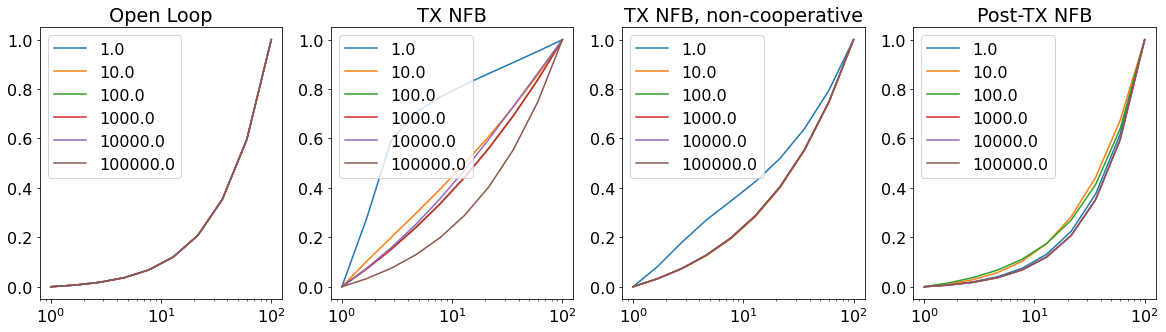

In [291]:
# normalize output
outs_norm = np.zeros((4,len(alphas),len(factors)))
for i in range(4):
    for j in range(len(factors)):
        outs_norm[i,:,j] = outs[i,:,j]-min(outs[i,:,j])
        outs_norm[i,:,j] = outs_norm[i,:,j] / max(outs_norm[i,:,j])

fig,ax = plt.subplots(1,4,figsize=(20,5))
titles = ['Open Loop','TX NFB','TX NFB, non-cooperative','Post-TX NFB']
for i,a in enumerate(ax):
    for f in range(len(factors)): 
        a.plot(alphas,outs_norm[i,:,f])
    a.set_xscale('log')
    #a.set_yscale('log')
    a.legend(factors)
    a.set_title(titles[i])

## Increasing translation rate

In [ ]:
def vary_input2(alphas,params,beta):
    out_ss = np.zeros((5,7,np.size(alphas)))
    tspan = [0,1e5]
    i0 = k_influx/k_degi
    l0 = k_d/k_a
    
    for a,alpha in enumerate(alphas):
        extra = [alpha,0]
        x0 = [i0, 0, 0, 0, 0, 0, 0]
        out_OL = sp.integrate.solve_ivp(ode_OL, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[0,:,a] = out_OL.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        out_TX = sp.integrate.solve_ivp(ode_TX, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        out_ss[1,:,a] = out_TX.y[:,-1]

        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_low = [alpha,beta]
        out_Rz = sp.integrate.solve_ivp(ode_Rz, tspan, x0, method='Radau', args=(params,extra_low), rtol=1e-10, atol=1e-10)
        out_ss[2,:,a] = out_Rz.y[:,-1]

        # OL ON
        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_on = [alpha,1e-1]
        out_Rz_off = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra_on), rtol=1e-10, atol=1e-10)
        out_ss[3,:,a] = out_Rz_off.y[:,-1]

        # OL OFF
        x0 = [i0, 0, 0, 0, 0, 0, 0]
        extra_off = [alpha,1e6]
        out_Rz_off = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra_off), rtol=1e-10, atol=1e-10)
        out_ss[4,:,a] = out_Rz_off.y[:,-1]

    return out_ss[:,6,:]

# Translation rate seems to be important
params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
alphas = np.logspace(0,2,40)
factors = np.logspace(0,5,6)
i = 13 # k_TL

outs = np.zeros((5,len(alphas),len(factors)))

for f,factor in enumerate(factors):
    params = params_orig
    #params[i] = params[i]*factor
    beta = factor
    out_ss = vary_input2(alphas,params,beta)
    outs[:,:,f] = out_ss

# Nice figure
colors = ['teal','darkturquoise','mediumturquoise','turquoise','paleturquoise','lightcyan']
alphas = np.logspace(0,2,10)
fig,ax = plt.subplots(1,1,figsize=(11,10))
ax.plot(alphas,outs[3,:,0],color='dimgray',linewidth=5) # OL ON
ax.plot(alphas,outs[4,:,0],color='darkgray',linewidth=5) # OL OFF
ax.plot(alphas,outs[1,:,0],color='steelblue',linewidth=5)
for f in range(len(factors)): 
    ax.plot(alphas,outs[2,:,f],color=colors[f],ls='--',linewidth=5)
ax.set_xscale('log')
ax.set_yscale('log')
leg = [str(f) for f in factors]
leg.insert(0,'TX NFB')
leg.insert(0,'OL OFF')
leg.insert(0,'OL ON')
#l = ax.legend(leg,loc=1,bbox_to_anchor=(1.1,0.9))
ax.legend(leg)
ax.set_title('Increasing translation rate of ligand', fontsize=20)
ax.set_xlabel('Factor increase in transcription', fontsize=20)
ax.set_ylabel('Steady state output protein level (molecules/cell)', fontsize=20)
fig.tight_layout()
#fig.savefig('./figs/vary-TL.jpg',dpi=300,bbox_extra_artists=(l,), bbox_inches='tight')
fig.savefig('./figs/vary-TL.jpg',dpi=300)

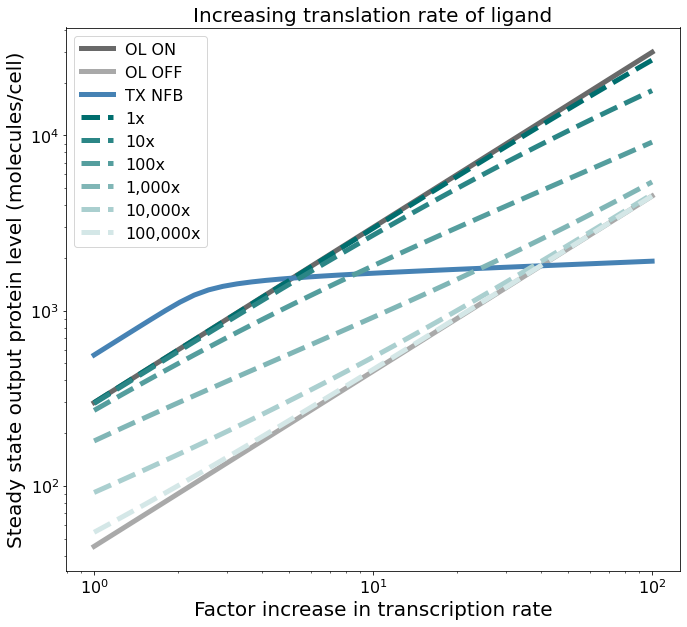

In [345]:
N = 7
color_teals = np.ones((N, 4))
color_teals[:, 0] = np.linspace(0/256, 1, N)
color_teals[:, 1] = np.linspace(110/256, 1, N)
color_teals[:, 2] = np.linspace(110/256, 1, N)

colors = ['teal','darkturquoise','mediumturquoise','turquoise','paleturquoise','lightcyan']
alphas = np.logspace(0,2,40)
fig,ax = plt.subplots(1,1,figsize=(11,10))
ax.plot(alphas,outs[3,:,0],color='dimgray',linewidth=5) # OL ON
ax.plot(alphas,outs[4,:,0],color='darkgray',linewidth=5) # OL OFF
ax.plot(alphas,outs[1,:,0],color='steelblue',linewidth=5)
for f in range(len(factors)): 
    ax.plot(alphas,outs[2,:,f],color=color_teals[f],ls='--',linewidth=5)
ax.set_xscale('log')
ax.set_yscale('log')
leg = ['OL ON','OL OFF','TX NFB','1x','10x','100x','1,000x','10,000x','100,000x']
#l = ax.legend(leg,loc=1,bbox_to_anchor=(1.1,0.9))
ax.legend(leg)
ax.set_title('Increasing translation rate of ligand', fontsize=20)
ax.set_xlabel('Factor increase in transcription rate', fontsize=20)
ax.set_ylabel('Steady state output protein level (molecules/cell)', fontsize=20)
fig.savefig('./figs/vary-TL.jpg')

## Increasing k_clb

In [379]:
# Next, try varying k_clb
params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
alphas = np.logspace(0,2,40)
factors = np.logspace(0,5,6)
i = 11 # k_clb

outs = np.zeros((5,len(alphas),len(factors)))

for f,factor in enumerate(factors):
    params = params_orig
    params[i] = params[i]*factor
    #beta = factor
    out_ss = vary_input2(alphas,params,beta)
    outs[:,:,f] = out_ss

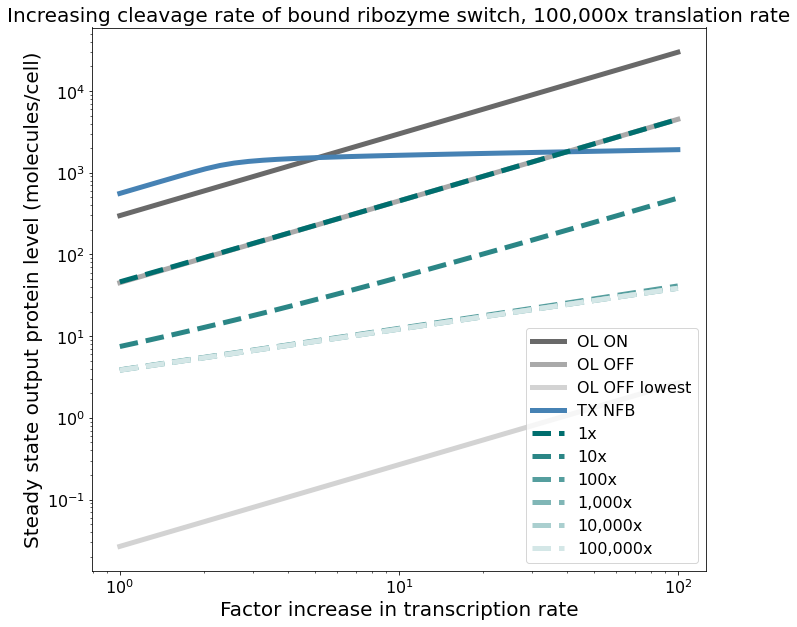

In [384]:
fig,ax = plt.subplots(1,1,figsize=(11,10))
ax.plot(alphas,outs[3,:,0],color='dimgray',linewidth=5) # OL ON
ax.plot(alphas,outs[4,:,0],color='darkgray',linewidth=5) # OL OFF
ax.plot(alphas,outs[4,:,5],color='lightgray',linewidth=5) # OL OFF lowest
ax.plot(alphas,outs[1,:,0],color='steelblue',linewidth=5) # TX NFB
for f in range(len(factors)): 
    ax.plot(alphas,outs[2,:,f],color=color_teals[f],ls='--',linewidth=5)
ax.set_xscale('log')
ax.set_yscale('log')
leg = ['OL ON','OL OFF','OL OFF lowest','TX NFB','1x','10x','100x','1,000x','10,000x','100,000x']
#l = ax.legend(leg,loc=1,bbox_to_anchor=(1.1,0.9))
ax.legend(leg)
ax.set_title('Increasing cleavage rate of bound ribozyme switch, 100,000x translation rate', fontsize=20)
ax.set_xlabel('Factor increase in transcription rate', fontsize=20)
ax.set_ylabel('Steady state output protein level (molecules/cell)', fontsize=20)
fig.savefig('./figs/vary-kclb_beta-1e5.jpg')

In [382]:
print(beta)

1000000.0


In [385]:
# Next, try varying k_clb
params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
alphas = np.logspace(0,2,40)
factors = np.logspace(0,5,6)
i = 11 # k_clb
beta = 1

outs = np.zeros((5,len(alphas),len(factors)))

for f,factor in enumerate(factors):
    params = params_orig
    params[i] = params[i]*factor
    #beta = factor
    out_ss = vary_input2(alphas,params,beta)
    outs[:,:,f] = out_ss

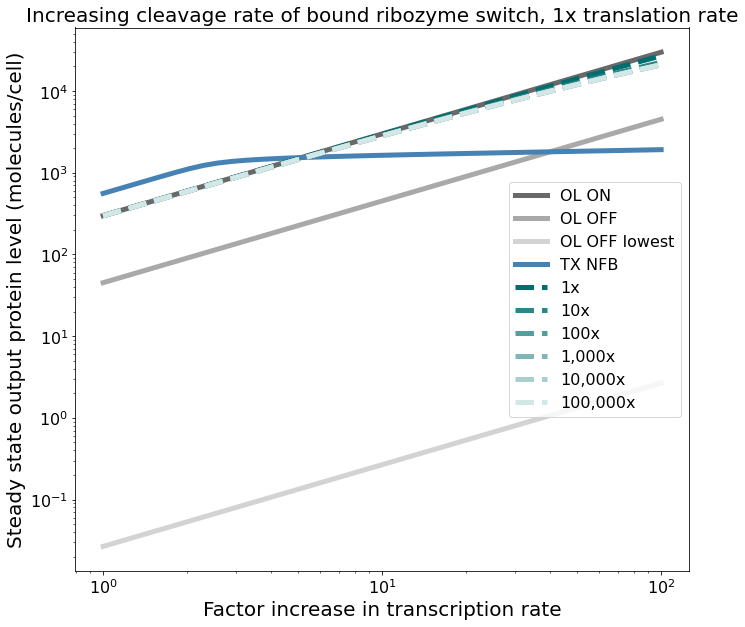

In [387]:
fig,ax = plt.subplots(1,1,figsize=(11,10))
ax.plot(alphas,outs[3,:,0],color='dimgray',linewidth=5) # OL ON
ax.plot(alphas,outs[4,:,0],color='darkgray',linewidth=5) # OL OFF
ax.plot(alphas,outs[4,:,5],color='lightgray',linewidth=5) # OL OFF lowest
ax.plot(alphas,outs[1,:,0],color='steelblue',linewidth=5) # TX NFB
for f in range(len(factors)): 
    ax.plot(alphas,outs[2,:,f],color=color_teals[f],ls='--',linewidth=5)
ax.set_xscale('log')
ax.set_yscale('log')
leg = ['OL ON','OL OFF','OL OFF lowest','TX NFB','1x','10x','100x','1,000x','10,000x','100,000x']
#l = ax.legend(leg,loc=1,bbox_to_anchor=(1.1,0.9))
ax.legend(leg)
ax.set_title('Increasing cleavage rate of bound ribozyme switch, 1x translation rate', fontsize=20)
ax.set_xlabel('Factor increase in transcription rate', fontsize=20)
ax.set_ylabel('Steady state output protein level (molecules/cell)', fontsize=20)
fig.savefig('./figs/vary-kclb_beta-1.jpg')

In [388]:
# Next, try varying k_clb
params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
alphas = np.logspace(0,2,40)
factors = np.logspace(0,5,6)
i = 11 # k_clb
beta = 1000

outs = np.zeros((5,len(alphas),len(factors)))

for f,factor in enumerate(factors):
    params = params_orig
    params[i] = params[i]*factor
    #beta = factor
    out_ss = vary_input2(alphas,params,beta)
    outs[:,:,f] = out_ss

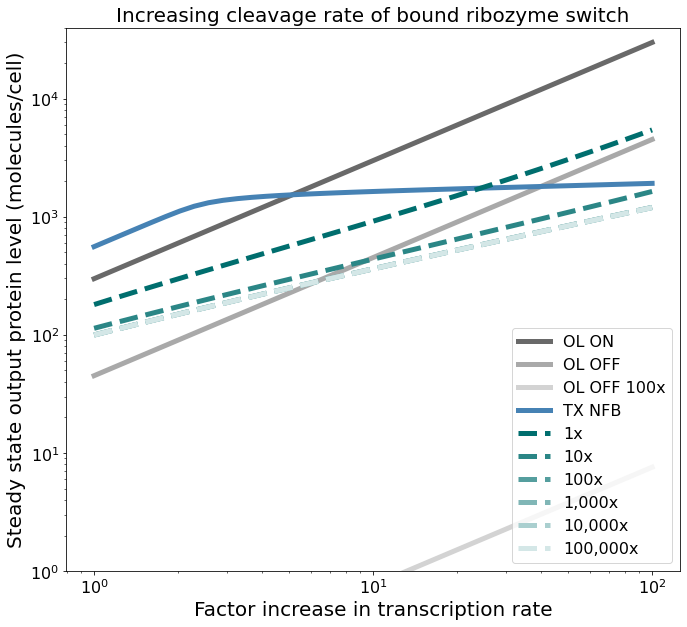

In [400]:
fig,ax = plt.subplots(1,1,figsize=(11,10))
ax.plot(alphas,outs[3,:,0],color='dimgray',linewidth=5) # OL ON
ax.plot(alphas,outs[4,:,0],color='darkgray',linewidth=5) # OL OFF
ax.plot(alphas,outs[4,:,2],color='lightgray',linewidth=5) # OL OFF lower
ax.plot(alphas,outs[1,:,0],color='steelblue',linewidth=5) # TX NFB
for f in range(len(factors)): 
    ax.plot(alphas,outs[2,:,f],color=color_teals[f],ls='--',linewidth=5)
ax.set_xscale('log')
ax.set_yscale('log')
leg = ['OL ON','OL OFF','OL OFF 100x','TX NFB','1x','10x','100x','1,000x','10,000x','100,000x']
#l = ax.legend(leg,loc=1,bbox_to_anchor=(1.1,0.9))
ax.legend(leg,loc='lower right')
ax.set_title('Increasing cleavage rate of bound ribozyme switch', fontsize=20)
ax.set_xlabel('Factor increase in transcription rate', fontsize=20)
ax.set_ylabel('Steady state output protein level (molecules/cell)', fontsize=20)
ax.set_ylim((1e0,4e4))
fig.savefig('./figs/vary-kclb_beta-1e3.jpg')

[]


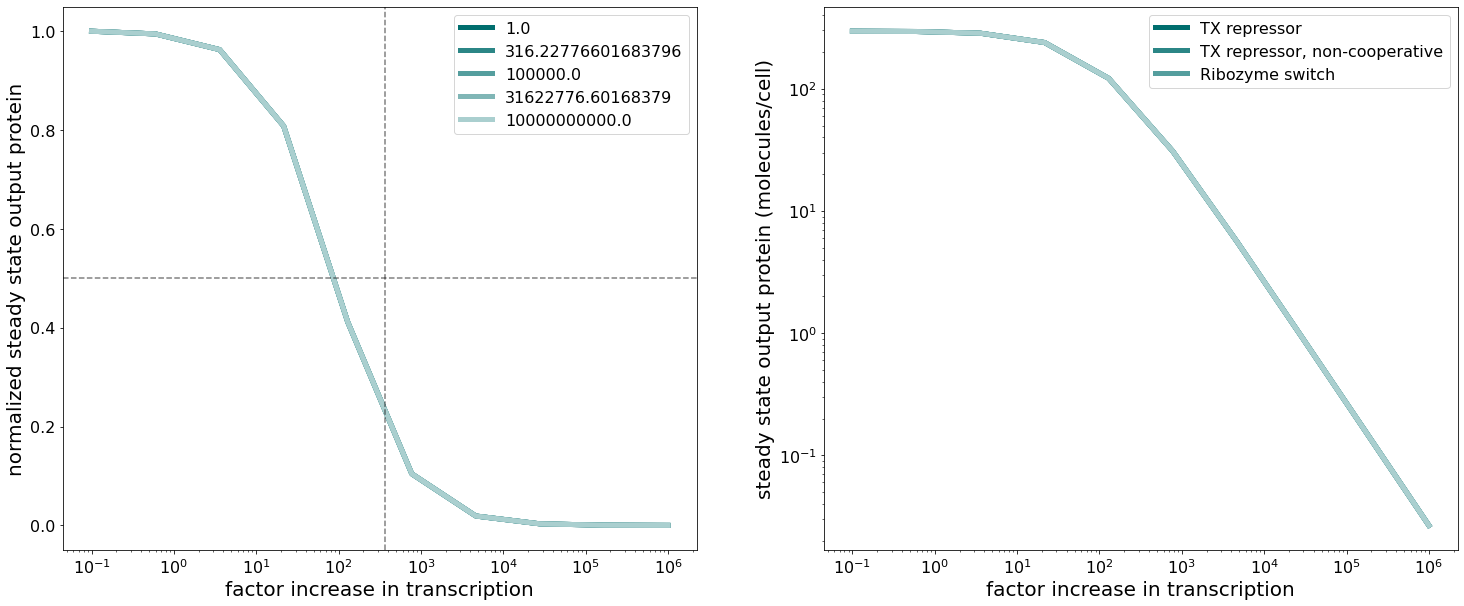

In [429]:
params_orig = [k_influx, k_degi, k_in, k_degl,  k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
tspan = [0,1e5]
i0 = k_influx/k_degi
l0 = k_d/k_a
alphas_Rz = np.logspace(-1,6,10)
outs_Rz = np.zeros((7,np.size(alphas_Rz)))
alpha = 1
i = 11 # k_clb
ks = np.logspace(0,10,5)
out_list = []

for k in ks:
    params = params_orig
    params[i] = params[i]*k
    for b,beta in enumerate(alphas_Rz):
        x0 = [i0, 0, 0, 0, 0, l0, 0]
        extra = [alpha,beta]
        out_Rz = sp.integrate.solve_ivp(ode_OL_Rz, tspan, x0, method='Radau', args=(params,extra), rtol=1e-10, atol=1e-10)
        outs_Rz[:,b] = out_Rz.y[:,-1]
    out_list.append(outs_Rz)

ns = []

fig,ax = plt.subplots(1,2,figsize=(25,10))

for i in range(len(out_list)):
    out = out_list[i]
    out_norm = out[6] - min(out[6])
    out_norm = out_norm / max(out_norm)
    ax[0].plot(alphas_Rz,out_norm[:100],color=color_teals[i],linewidth=5)
    ax[1].plot(alphas_Rz,out[6,:100],color=color_teals[i],linewidth=5)

print(ns)
ax[0].set_xscale('log')
ax[0].legend(ks)
ax[0].set_xlabel('factor increase in transcription', fontsize=20)
ax[0].set_ylabel('normalized steady state output protein', fontsize=20)
ax[0].axhline(0.5,color='black',alpha=0.5,ls='--')
#ax[0].axvline(2.8,color='black',alpha=0.5,ls='--')
ax[0].axvline(3.7e2,color='black',alpha=0.5,ls='--')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(['TX repressor','TX repressor, non-cooperative','Ribozyme switch'])
ax[1].set_xlabel('factor increase in transcription', fontsize=20)
ax[1].set_ylabel('steady state output protein (molecules/cell)', fontsize=20)
#ax[1].set_ylim((1e0,1e6))

fig.savefig('./figs/dose-response-2.jpg')

[]


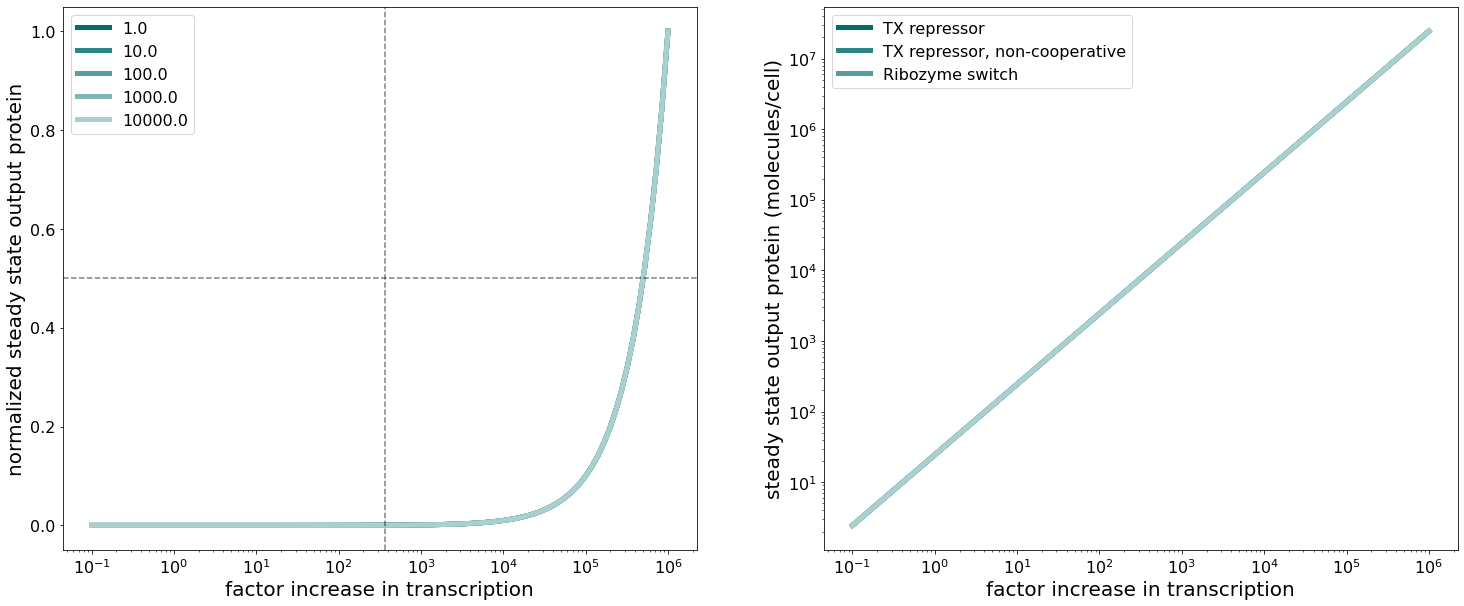

In [426]:
fig,ax = plt.subplots(1,2,figsize=(25,10))

for i in range(len(out_list)):
    out = out_list[i]
    out_norm = out[6] - min(out[6])
    out_norm = out_norm / max(out_norm)
    ax[0].plot(alphas_Rz,out_norm[:100],color=color_teals[i],linewidth=5)
    ax[1].plot(alphas_Rz,out[6,:100],color=color_teals[i],linewidth=5)

print(ns)
ax[0].set_xscale('log')
ax[0].legend(ks)
ax[0].set_xlabel('factor increase in transcription', fontsize=20)
ax[0].set_ylabel('normalized steady state output protein', fontsize=20)
ax[0].axhline(0.5,color='black',alpha=0.5,ls='--')
#ax[0].axvline(2.8,color='black',alpha=0.5,ls='--')
ax[0].axvline(3.7e2,color='black',alpha=0.5,ls='--')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(['TX repressor','TX repressor, non-cooperative','Ribozyme switch'])
ax[1].set_xlabel('factor increase in transcription', fontsize=20)
ax[1].set_ylabel('steady state output protein (molecules/cell)', fontsize=20)
#ax[1].set_ylim((1e0,1e6))

fig.savefig('./figs/dose-response-2.jpg')

In [423]:
print(len(color_teals))

7


## Varying other parameters

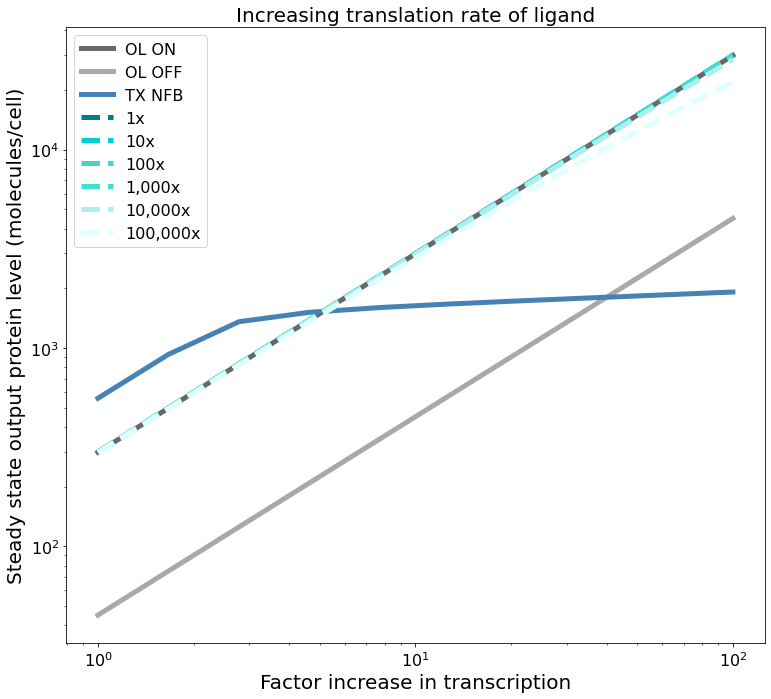

In [333]:
def vary_param(i,name):
    #factors = np.logspace(0,5,6)
    factors = np.logspace(-5,0,6)
    alphas = np.logspace(0,2,10)
    outs = np.zeros((5,len(alphas),len(factors)))

    for f,factor in enumerate(factors):
        params = params_orig
        params[i] = params[i]*factor
        beta = factor
        out_ss = vary_input2(alphas,params,beta)
        outs[:,:,f] = out_ss

    # Nice figure
    colors = ['teal','darkturquoise','mediumturquoise','turquoise','paleturquoise','lightcyan']
    #alphas = np.logspace(0,2,40)
    fig,ax = plt.subplots(1,1,figsize=(11,10))
    ax.plot(alphas,outs[3,:,0],color='dimgray',linewidth=5) # OL ON
    ax.plot(alphas,outs[4,:,0],color='darkgray',linewidth=5) # OL OFF
    ax.plot(alphas,outs[1,:,0],color='steelblue',linewidth=5)
    for f in range(len(factors)): 
        ax.plot(alphas,outs[2,:,f],color=colors[f],ls='--',linewidth=5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    leg = ['OL ON','OL OFF','TX NFB','1x','10x','100x','1,000x','10,000x','100,000x']
    #l = ax.legend(leg,loc=1,bbox_to_anchor=(1.1,0.9))
    ax.legend(leg)
    ax.set_title('Increasing translation rate of ligand', fontsize=20)
    ax.set_xlabel('Factor increase in transcription', fontsize=20)
    ax.set_ylabel('Steady state output protein level (molecules/cell)', fontsize=20)
    fig.tight_layout()
    #fig.savefig('./figs/vary-TL.jpg',dpi=300,bbox_extra_artists=(l,), bbox_inches='tight')
    fig.savefig('./figs/vary-'+name+'.jpg')

params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
idx = [9] # k_d
names = 'k_d'

for i,name in zip(idx,names):
    vary_param(i,name)

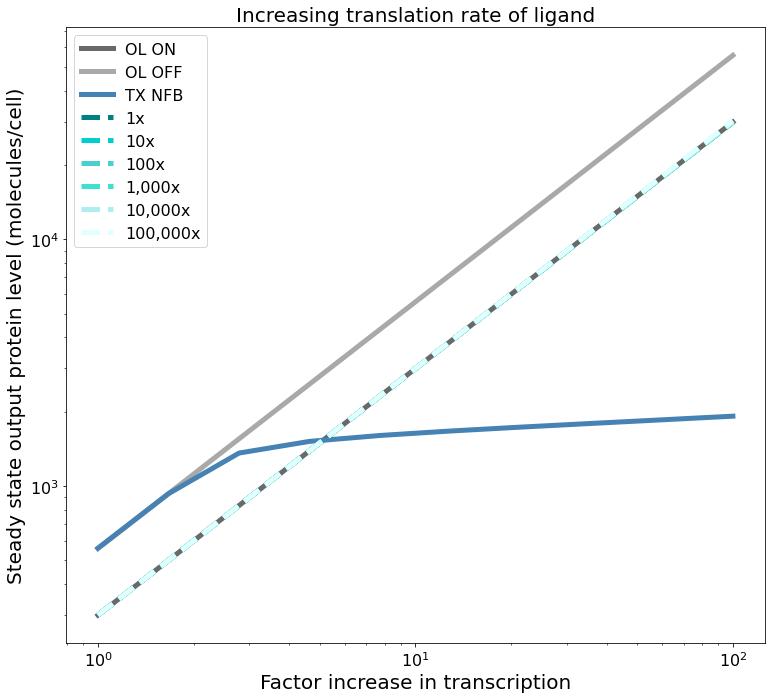

In [334]:
params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
vary_param(11,'k_clb')

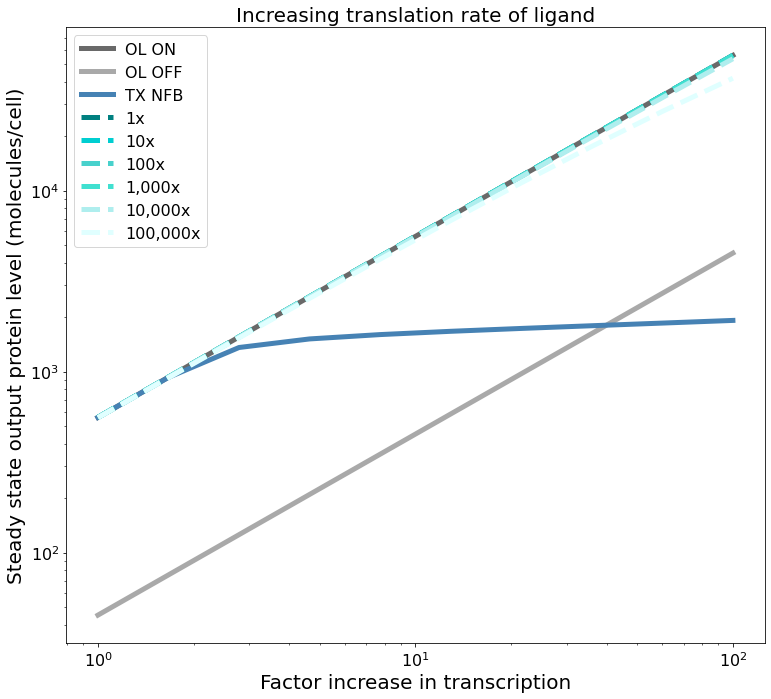

In [335]:
params_orig = [k_influx, k_degi, k_in, k_degl, k_on, k_off, k_degp, k_degm, k_a, k_d, k_cl, k_clb, k_TX, k_TL, theta, n]
vary_param(10,'k_cl')

Text(0, 0.5, 'Steady state output protein level (molecules/cell)')

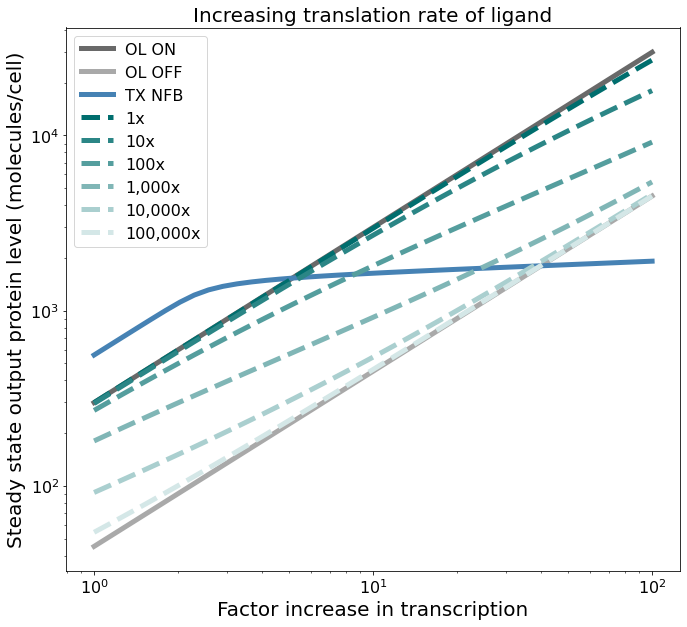